In [2]:
%load_ext autoreload
import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [3]:

from oodeel.datasets.load import load_dataset

num_classes = 10
input_shape = (28, 28, 1)

#### MNIST

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = load_dataset("mnist")

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### Fashion MNIST

# Load the data and split it between train and test sets
_ , (x_ood, y_ood) = load_dataset("fashion_mnist")

# Scale images to the [0, 1] range
x_ood = x_ood.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_ood = np.expand_dims(x_ood, -1)


In [5]:
model = get_model("../saved_models/mnist_model")


## Maximum Logit Score
(A good classifier is all you need ?)

Example of method that does not need ID data to compute statistics to compare against

In [7]:

oodmodel = MLS(model)
scores_id = oodmodel.score(x_test)
scores_ood = oodmodel.score(x_ood)

313/313 [==============================] - 2s 6ms/step


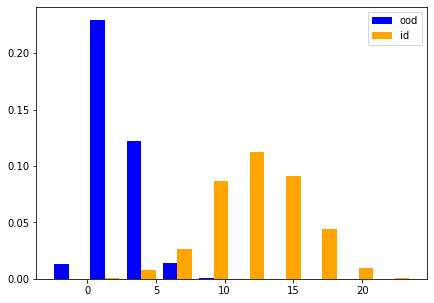

In [8]:
plt.figure(figsize=(7,5))

plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

[1.     0.9999 0.9995 ... 0.     0.     0.    ] [1.e+00 1.e+00 1.e+00 ... 7.e-04 3.e-04 0.e+00]
0.9947957849999999


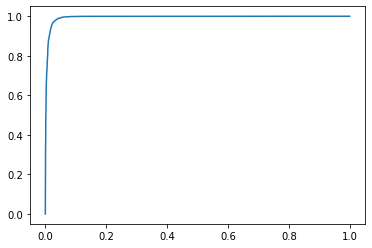

In [39]:
%autoreload 2
from oodeel.eval.metrics import bench_metrics, curve

scores = - np.concatenate([scores_id, scores_ood]) #ood has to be higher
labels = np.concatenate([np.zeros(scores_id.shape), np.ones(scores_ood.shape)])

tpc, fpc, tnc, fnc = curve(scores, labels, step=4)
tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])
auroc = bench_metrics(scores, labels)

print(fpr, tpr)
print(auroc)
plt.plot(fpr, tpr)
plt.show()

## Deep KNN
Example of method that needs ID data to compute statistics to compare against

In [9]:
%autoreload 2
oodmodel = DKNN(model)
oodmodel.fit(x_train[:20000])

625/625 [==============================] - 4s 6ms/step


In [10]:
scores_id = oodmodel.score(x_test[:1000], 30)
scores_ood = oodmodel.score(x_ood[:1000], 30)

32/32 [==============================] - 0s 6ms/step


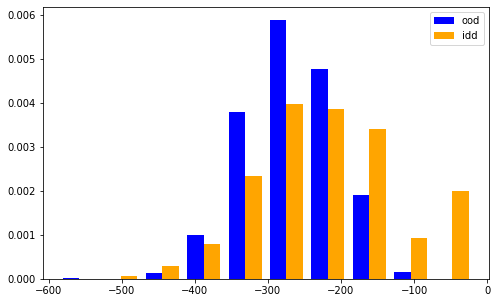

In [11]:
plt.figure(figsize=(8,5))

plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "idd"), density=True)
plt.legend()
plt.show()